In [1]:
# import modules
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

import re

import nltk
import numpy as np
from keras.layers import Flatten, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, one_hot
from nltk.corpus import stopwords
from numpy import array, asarray, zeros
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# clone github (commenting for local machine)
#!git clone https://github.com/saurabh-khanna/cs230.git

In [3]:
# read in data
txt_folder = Path("data_cs230").rglob("*.txt")
files = [x for x in txt_folder]

In [4]:
# read all files to two Python lists
filename = []
content = []
for name in files:
    # print(name)
    f = open(name, "r")
    # split name of title from extension
    f_name, f_ext = os.path.splitext(name)
    filename.append(f_name[len(f_name) - 3])
    content.append(f.readlines()[0])
    f.close()

In [5]:
# add it into dataframe
df = pd.DataFrame({"political_affiliation": filename, "speech_text": content})
df

,political_affiliation,speech_text
0,R,"mr. chairman , i am supportive , but my unders..."
1,D,"mr. chairman , i yield 5 minutes to the gentle..."
2,R,"mr. speaker , i yield myself 2 minutes . mr. ..."
3,D,"mr. speaker , the work of this subcommittee ha..."
4,D,"mr. speaker , reclaiming my time , i thank aga..."
...,...,...
3842,D,"mr. chairman , i demand a recorded vote ."
3843,R,"mr. speaker , i rise in support of s. 5 , the ..."
3844,R,"i appreciate the gentleman yielding to me , mr..."
3845,R,"mr. chairman , i move to strike the last word ..."


## Data Pre-processing

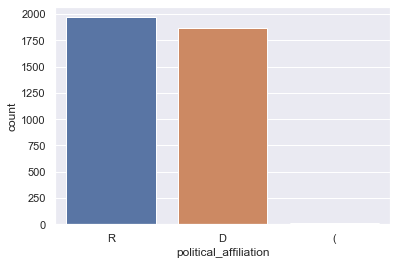

In [6]:
# descriptives
sns.countplot(x="political_affiliation", data=df)

In [7]:
def preprocess_text(text):
    # Remove punctuations and numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    # Removing multiple spaces
    text = re.sub(r"\s+", " ", text)
    return text

In [8]:
df["speech_text_clean"] = df.apply(
    lambda row: preprocess_text(row["speech_text"]), axis=1
)
df

,political_affiliation,speech_text,speech_text_clean
0,R,"mr. chairman , i am supportive , but my unders...",mr chairman am supportive but my understanding...
1,D,"mr. chairman , i yield 5 minutes to the gentle...",mr chairman yield minutes to the gentlewoman f...
2,R,"mr. speaker , i yield myself 2 minutes . mr. ...",mr speaker yield myself minutes mr speaker jus...
3,D,"mr. speaker , the work of this subcommittee ha...",mr speaker the work of this subcommittee has a...
4,D,"mr. speaker , reclaiming my time , i thank aga...",mr speaker reclaiming my time thank again the ...
...,...,...,...
3842,D,"mr. chairman , i demand a recorded vote .",mr chairman demand recorded vote
3843,R,"mr. speaker , i rise in support of s. 5 , the ...",mr speaker rise in support of the class action...
3844,R,"i appreciate the gentleman yielding to me , mr...",i appreciate the gentleman yielding to me mr s...
3845,R,"mr. chairman , i move to strike the last word ...",mr chairman move to strike the last word do so...


In [9]:
# creating a binary label for classification
# only 19 speeches for independent candidates, so clubbing them with republicans
df["republican"] = 1
df.loc[df["political_affiliation"] == "D", "republican"] = 0
df

,political_affiliation,speech_text,speech_text_clean,republican
0,R,"mr. chairman , i am supportive , but my unders...",mr chairman am supportive but my understanding...,1
1,D,"mr. chairman , i yield 5 minutes to the gentle...",mr chairman yield minutes to the gentlewoman f...,0
2,R,"mr. speaker , i yield myself 2 minutes . mr. ...",mr speaker yield myself minutes mr speaker jus...,1
3,D,"mr. speaker , the work of this subcommittee ha...",mr speaker the work of this subcommittee has a...,0
4,D,"mr. speaker , reclaiming my time , i thank aga...",mr speaker reclaiming my time thank again the ...,0
...,...,...,...,...
3842,D,"mr. chairman , i demand a recorded vote .",mr chairman demand recorded vote,0
3843,R,"mr. speaker , i rise in support of s. 5 , the ...",mr speaker rise in support of the class action...,1
3844,R,"i appreciate the gentleman yielding to me , mr...",i appreciate the gentleman yielding to me mr s...,1
3845,R,"mr. chairman , i move to strike the last word ...",mr chairman move to strike the last word do so...,1


In [10]:
X = df["speech_text_clean"]  # input
y = df["republican"]  # labels

# 75/25 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=100
)

In [11]:
# Preparing the embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
# Find the vocabulary size and then perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

In [13]:
# load the GloVe word embeddings and create a dictionary
embeddings_dictionary = dict()
glove_file = open(
    "/home/saurabh/Everything/PhD/Courses/9. Autumn 2020/CS 230/cs230/glove/glove.6B.100d.txt",
    encoding="utf8",
)

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [14]:
# create embedding matrix
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Models
### Model 0: Logistic Regression

In [15]:
# create a sequential model
model = Sequential()
# create and add embedding layer
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
# adding dense layer with sigmoid activation
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
# compile model with sgd optimizer
model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["binary_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1837200   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 1,847,201
Trainable params: 10,001
Non-trainable params: 1,837,200
_________________________________________________________________


In [16]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 0s 3ms/step - loss: 0.9980 - binary_accuracy: 0.5067 - val_loss: 1.1406 - val_binary_accuracy: 0.5180
Epoch 2/50
68/68 [==============================] - 0s 2ms/step - loss: 0.8481 - binary_accuracy: 0.5640 - val_loss: 0.8155 - val_binary_accuracy: 0.5471
Epoch 3/50
68/68 [==============================] - 0s 2ms/step - loss: 0.7357 - binary_accuracy: 0.6093 - val_loss: 0.7062 - val_binary_accuracy: 0.5554
Epoch 4/50
68/68 [==============================] - 0s 2ms/step - loss: 0.6689 - binary_accuracy: 0.6533 - val_loss: 0.7758 - val_binary_accuracy: 0.5457
Epoch 5/50
68/68 [==============================] - 0s 3ms/step - loss: 0.5334 - binary_accuracy: 0.7374 - val_loss: 1.2063 - val_binary_accuracy: 0.5360
Epoch 6/50
68/68 [==============================] - 0s 2ms/step - loss: 0.5696 - binary_accuracy: 0.7138 - val_loss: 0.8015 - val_binary_accuracy: 0.5665
Epoch 7/50
68/68 [==============================] - 0s 2ms/step - loss: 0.50

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

31/31 [==============================] - 0s 1ms/step - loss: 0.8454 - binary_accuracy: 0.5800
Test Accuracy: 0.5800415873527527


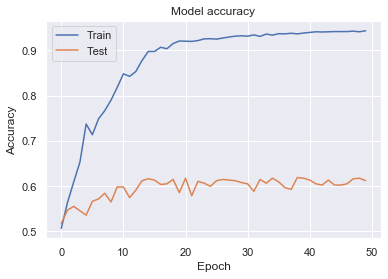

In [18]:
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["Train", "Test"], loc="upper left")

### Model 1: Simple Neural Network

In [19]:
# create a sequential model
model = Sequential()
# create and add embedding layer
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
# adding dense layer with sigmoid activation
model.add(Flatten())
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)

# compile model with adam optimizer
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1837200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                240024    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 0s 6ms/step - loss: 1.3422 - acc: 0.5095 - val_loss: 1.1332 - val_acc: 0.5305
Epoch 2/50
68/68 [==============================] - 0s 4ms/step - loss: 1.0353 - acc: 0.5765 - val_loss: 0.9723 - val_acc: 0.5388
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.9046 - acc: 0.6662 - val_loss: 0.9372 - val_acc: 0.5693
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.7688 - acc: 0.7577 - val_loss: 0.9542 - val_acc: 0.6039
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6369 - acc: 0.8280 - val_loss: 1.0438 - val_acc: 0.5886
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.5465 - acc: 0.8770 - val_loss: 1.1595 - val_acc: 0.6066
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.4824 - acc: 0.9011 - val_loss: 1.1954 - val_acc: 0.6011
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 0.4805 - acc: 0.90

In [21]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

31/31 [==============================] - 0s 3ms/step - loss: 1.4231 - acc: 0.5936
Test Accuracy: 0.5935550928115845


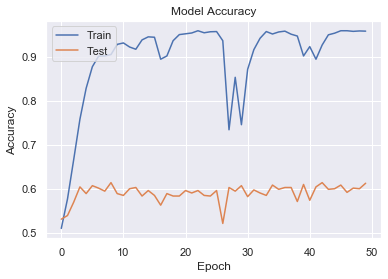

In [22]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")

### Model 2: Convolutional Neural Net

In [23]:
model = Sequential()

embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(
    Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.0075))
)
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1837200   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 24)               

In [24]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.25
)

Epoch 1/50
68/68 [==============================] - 1s 15ms/step - loss: 1.3516 - acc: 0.5460 - val_loss: 1.1721 - val_acc: 0.5845
Epoch 2/50
68/68 [==============================] - 1s 14ms/step - loss: 1.0313 - acc: 0.6523 - val_loss: 0.9964 - val_acc: 0.5762
Epoch 3/50
68/68 [==============================] - 1s 14ms/step - loss: 0.8124 - acc: 0.7282 - val_loss: 0.8761 - val_acc: 0.6247
Epoch 4/50
68/68 [==============================] - 1s 14ms/step - loss: 0.5750 - acc: 0.8460 - val_loss: 0.8413 - val_acc: 0.6565
Epoch 5/50
68/68 [==============================] - 1s 14ms/step - loss: 0.3969 - acc: 0.9251 - val_loss: 1.0673 - val_acc: 0.6163
Epoch 6/50
68/68 [==============================] - 1s 14ms/step - loss: 0.3146 - acc: 0.9445 - val_loss: 0.9255 - val_acc: 0.6662
Epoch 7/50
68/68 [==============================] - 1s 14ms/step - loss: 0.2602 - acc: 0.9542 - val_loss: 0.9640 - val_acc: 0.6537
Epoch 8/50
68/68 [==============================] - 1s 14ms/step - loss: 0.2402 - a

In [25]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

31/31 [==============================] - 0s 5ms/step - loss: 0.7993 - acc: 0.6902
Test Accuracy: 0.6902287006378174


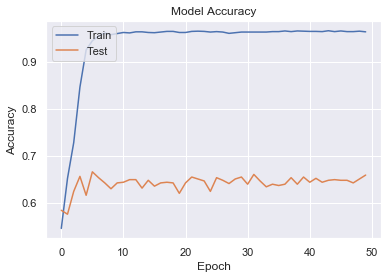

In [26]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")

### Model 3: LSTM-RNN

In [27]:
model = Sequential()
embedding_layer = Embedding(
    vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False
)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1837200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_11 (Dense)             (None, 24)                3096      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)               

In [28]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=80, verbose=1, validation_split=0.25
)

Epoch 1/80
68/68 [==============================] - 6s 84ms/step - loss: 0.6947 - acc: 0.5229 - val_loss: 0.6933 - val_acc: 0.5014
Epoch 2/80
68/68 [==============================] - 6s 82ms/step - loss: 0.6921 - acc: 0.5243 - val_loss: 0.6926 - val_acc: 0.5097
Epoch 3/80
68/68 [==============================] - 6s 82ms/step - loss: 0.6935 - acc: 0.5150 - val_loss: 0.6934 - val_acc: 0.5097
Epoch 4/80
68/68 [==============================] - 6s 82ms/step - loss: 0.6925 - acc: 0.5164 - val_loss: 0.6932 - val_acc: 0.5111
Epoch 5/80
68/68 [==============================] - 5s 80ms/step - loss: 0.6934 - acc: 0.5164 - val_loss: 0.6930 - val_acc: 0.5097
Epoch 6/80
68/68 [==============================] - 6s 87ms/step - loss: 0.6925 - acc: 0.5206 - val_loss: 0.6927 - val_acc: 0.5083
Epoch 7/80
68/68 [==============================] - 6s 84ms/step - loss: 0.6904 - acc: 0.5331 - val_loss: 0.6914 - val_acc: 0.5291
Epoch 8/80
68/68 [==============================] - 6s 82ms/step - loss: 0.6896 - a

In [29]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

31/31 [==============================] - 1s 24ms/step - loss: 2.2566 - acc: 0.5800
Test Accuracy: 0.5800415873527527


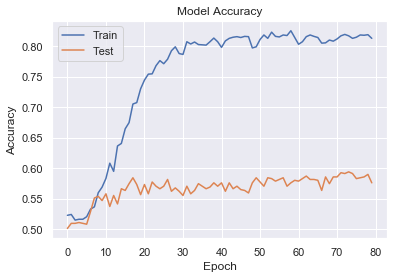

In [30]:
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["Train", "Test"], loc="upper left")